# PID 101 for Robotics: Part I

Copyright &copy; 2023 [Joshua Marshall](https://www.ece.queensu.ca/people/j-marshall)

The purpose of this hands-on notebook is to provide a brief tutorial introduction to the feedback control of simple single-input, single-output (SISO) systems. Practitioners in robotics are the intended audience, although the concepts are applicable more broadly.  

The focus here is on understanding the Proportional-Integral-Derivative (PID) control structure, which is widely used but often poorly understood. Readers may wish to refer to an undergraduate-level textbook, such as [[1]](#references), for a more detailed treatment. 

What is perhaps unique in this notebook is that we introduce PID control solely in the time domain (i.e., without reliance on Laplace domain techniques), which is arguably more intuitive.

## Simple Mobile Robot

Let's use a really simple 1D mobile robot (or vehicle, if you prefer) as platform for learning.  To start, we need a model.  Let $v(t)$ [m/s] be the speed of a mobile robot that travels in a straight line and suppose that it has mass $m>0$ $[\rm{kg}]$, a drag coefficient $c_{\rm d}>0$ $[\rm{kg}/\rm{s}]$, and that its wheels generate a force $u(t)\in\mathbb{R}$ $[\rm{N}]$ that we get to choose.  Applying Newton's Second Law, we find

$$u(t)-c_{\rm d}v(t)=m\dot{v}(t),$$

or equivalently (in a more standard form),

$$\dot{v}(t) = -\frac{c_{\rm d}}{m}v(t) + \frac{1}{m}u(t).$$

Notice how this model is conveniently _linear_ (i.e., it obeys the [superposition principle](https://en.wikipedia.org/wiki/Superposition_principle)). 

Now let's simulate the robot's response to inputs $u(t)$.  Once we have that working, we can drive our (virtual) robot around and learn how to solve some control problems.

### Python Packages

In this notebook we use the Python packages [NumPy](http://numpy.org) for arrays and [Matplotlib](http://matplotlib.org) for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


### Simulation Setup

Set the simulation time as `SIM_TIME` [s], the sample period $T>0$ as `T` [s], the mobile robot's mass $m$ as `MASS` [kg], and the drag coefficient $c_{\rm d}$ as `C_DRAG` [kg/s].

In [2]:
SIM_TIME = 10.0
T = 0.1
MASS = 1.5
C_DRAG = 2.0


 Set up an array of simulation times `t` and find the total number of simulation data points `N`.

In [3]:
t = np.arange(0, SIM_TIME, T)
N = np.size(t)


 Write a function to model the mobile robot's speed $v$ as `v` [m/s] as a function of the force input $u$ as `u` [N], where $u_k=u(kT)$, $k=0,1,2,\ldots$ is applied as a [zero-order hold](https://en.wikipedia.org/wiki/Zero-order_hold) such that

 $$v_{k+1} = v_{k} + T \frac{1}{m}(u_k - c_{\rm{d}}v_k).$$

In [4]:
def robot_speed(v, u, T):
    """Discrete-time 1D mobile robot speed model."""

    v_new = v + T * 1 / MASS * (u - C_DRAG * v)
    return v_new


### Simulate the Robot's Motion

Initialize the variable arrays and the initial conditions

In [5]:
v = np.zeros(N)
u = np.zeros(N)

# Change these if you want to change the initial conditions
v[0] = 0.0
u[0] = 0.0


For each time step, simulate the vehicle motion.  

>__Exercise:__ Go ahead and play with $u_k$.

In [6]:
for k in range(1, N):

    # Run the vehicle speed model for one time step
    v[k] = robot_speed(v[k - 1], u[k - 1], T)

    # Create an open loop input (play with this input command)
    u[k] = 2.0 * np.sin(k * T)


### Plot the Simulation Output

Let's plot the simulation output.  Start with some optional setup items for plotting.

In [7]:
# So we can use LaTeX in our text
plt.rc("text", usetex=True)

# So we can use some additional math features in our text
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")


Plot the robot's speed $v(t)$ and corresponding input $u(t)$.

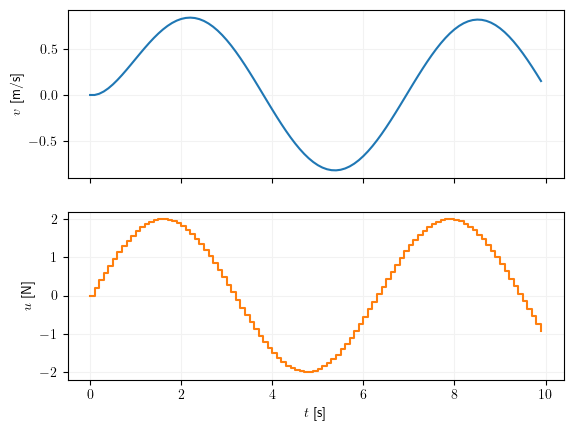

In [8]:
fig1 = plt.figure(1)
# Plot the speed
ax1a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax1a, xticklabels=[])
# Plot the input
ax1b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
plt.show()


Now that we have a working robot simulator, we can start looking at some control problems.

## Proportional (P) Control

Suppose we want a control system that automatically computes the inputs $u(t)$ to have the robot track a desired constant speed setting $v_{\rm{d}}$ $[\rm{m}/\rm{s}]$ (i.e., like the cruise control system in your car).

Let $e(t):=v_{\rm{d}}-v(t)$ be the error between the desired speed (e.g., set by the user) and the robot's actual speed.  Thus, the control problem is to find $u(t)$ such that $e(t)\rightarrow 0$ as $t\rightarrow\infty$ (i.e., make the error go to zero).  

We start by computing the _error dynamics_

$$\dot{e}(t) = 0 - \dot{v}(t) = \frac{c_{\rm{d}}}{m}v(t) - \frac{1}{m}u(t) = \frac{c_{\rm{d}}}{m}(v_{\rm{d}}-e(t)) - \frac{1}{m}u(t).$$

Let's guess a control law!  The most simple feedback control structure is _proportional_ (P) control.  In this case, choose

$$u(t) = k_{\rm{P}}e(t) + c_{\rm{d}}v_{\rm{d}},$$

where $k_{\rm{P}}\in\mathbb{R}$ is called the proportional gain and the term $c_{\rm{d}}v_{\rm{d}}$ is called a _feed-forward_ term.  Substituting this into the error dynamics above yields

$$\dot{e}(t) = -\frac{1}{m}\left(c_{\rm{d}}+k_{\rm{P}}\right)e(t).$$

Check for yourself (e.g., you could use the Laplace transform) that the solution to this ODE is

$$e(t) = e(0)e^{-\frac{1}{m}\left(c_{\rm{d}}+k_{\rm{P}}\right)t}$$

for $t\geq 0$ and initial error $e(0)$. In other words $e(t)\rightarrow 0$ as $t\rightarrow\infty$ if $k_{\rm{P}}>-c_{\rm{d}}$.  Let's try our design in simulation.  

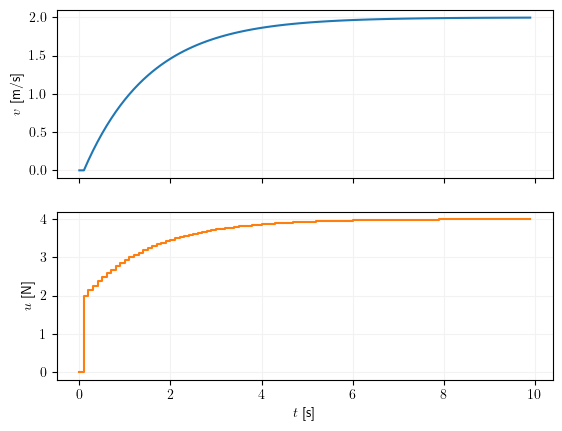

In [9]:
# Pick the desired speed a proportional gain (play with this gain)
V_DESIRED = 2.0
K_P = -C_DRAG + 1.0

# Set the initial conditions
v[0] = 0.0
u[0] = 0.0

# Simulate the closed-loop response
for k in range(1, N):
    v[k] = robot_speed(v[k - 1], u[k - 1], T)
    u[k] = K_P * (V_DESIRED - v[k]) + C_DRAG * V_DESIRED

# Plot the simulation output
fig2 = plt.figure(2)
# Plot the speed
ax2a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax2a, xticklabels=[])
# Plot the input
ax2b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
plt.show()


>__Exercise:__ Explore these questions on your own by editing the code: 
>
>1. What happens as you increase $k_{\rm{P}}$?  
>2. What happens if you don't apply the feed-forward term $c_{\rm{d}}v_{\rm{d}}$?
>3. What if there is a maximum force that the robot's motor is able generate?

## Proportional-Integral (PI) Control

What if we don't precisely know the value of $c_{\rm{d}}$?  Or, what if our vehicle encounters a hill?  Will our proportional-only controller (with feed-forward) design still work?  Convince yourself (either mathematically or by a simulation experiment) that the answer is that no it will not—at least, not perfectly.

### Integral Action

This is where _integral action_ comes in.  Let's add an extra term to our controller design that tries to learn the feed-forward term and even the extra resistance due to gravity?  You can prove this will work; e.g., see any undergraduate level controls book, such as [[1]](#references).  However, let's just implement this design and show that it works via simulation.

In this case, we implement the _proportional-integral_ (PI) controller

$$u(t)=k_{{\rm P}}(v_{\rm{d}}-v(t)) + k_{{\rm I}}\int_0^t(v_{\rm{d}}-v(\tau))\rm{d}\tau,$$

where $k_{\rm{I}}\in\mathbb{R}$ is the integral gain. In discrete time (e.g., in code), we implement this design as

$$u_k=k_{{\rm P}}(v_{\rm{d}}-v_k) + k_{{\rm I}}T\sum_{i=0}^k(v_{\rm{d}}-v_i).$$

Let's create a class `PI_Controller` for a PI controller design.  This specific implementation is perhaps a bit more complex than it needs to be, but we do it this way to make the code generalizable and portable to an actual application.

In [10]:
class PI_Controller:
    """Proportional-Integral (PI) controller class."""

    def __init__(self, k_P, k_I, u_max, T):
        """Constructor method.

        Parameters
        ----------
        k_P : float
            Proportional gain.
        k_I : float
            Integral gain.
        u_max : float
            Maximum control signal output magnitude.
        T : float
            Sample period [s].
        """

        self.k_P = k_P
        self.k_I = k_I
        self.T = T
        self.e_integral = 0.0
        self.u_max = u_max

    def compute_PI(self, e):
        """Compute the controller output.

        Parameters
        ----------
        e : float
            Error signal.

        Returns
        -------
        u : float
            Control signal (controller output).
        """

        # Compute the control signal output
        u = self.k_P * e + self.k_I * self.e_integral

        # Check for control signal saturation
        if u >= abs(self.u_max):
            # Saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # Only integrate if control signal is not saturated (anti-windup)
            self.e_integral += self.T * e

        return u


Now let's simulate our vehicle with a controller design that has no prior knowledge about the exact nature of the drag coefficient.  

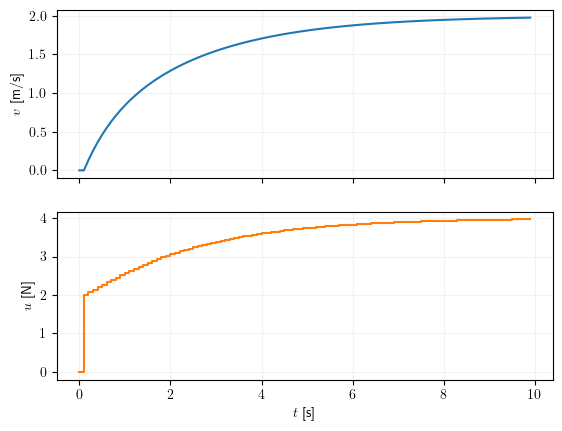

In [11]:
# Pick the desired speed a proportional gain (play with this gain)
V_DESIRED = 2.0
K_P = 1.0
K_I = 1.0
U_MAX = 20.0

# Instantiate a controller class
controller = PI_Controller(K_P, K_I, U_MAX, T)

# Set the initial conditions
v[0] = 0.0
u[0] = 0.0

# Simulate the closed-loop response
for k in range(1, N):
    v[k] = robot_speed(v[k - 1], u[k - 1], T)
    u[k] = controller.compute_PI(V_DESIRED - v[k])

# Plot the simulation output
fig3 = plt.figure(3)
# Plot the speed
ax3a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax3a, xticklabels=[])
# Plot the input
ax3b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
plt.show()


>__Exercise:__ Explore these questions on your own by editing the code: 
>
>1. What happens as you change $k_{\rm{P}}$ and $k_{\rm{I}}$?
>2. See what happens when you set the value of `U_MAX` such that your control input saturates.

>__Exercise:__ Maybe you don't precisely know the feed-forward signal $v_{\rm{d}}c_{\rm{d}}$, but that does not necessarily mean that it is not useful and should be discarded.  Edit the example above to combine both feed-forward and integral action to affect the robot's transient performance.

There is rarely a case when we know everything, and so integral action is quite a useful tool for almost all control problems.

## Proportional-Derivative (PD) Control

Suppose that we now want to solve a parking problem, instead of a cruise control problem for our mobile robot.  In this case, we can re-write the equations of motion for the robot in terms of its position $x\in\mathbb{R}$, such that

$$\begin{align*}\dot{x}(t) &= v(t) \\ \dot{v}(t) &= -\frac{c_{\rm d}}{m}v(t) + \frac{1}{m}u(t).\end{align*}$$ 

Let's rename our variables, called _states_, $x_1:=x$ and $x_2:=v$ so that

$$\begin{align*}\dot{x}_1(t) &= x_2(t) \\ \dot{x}_2(t) &= -\frac{c_{\rm d}}{m}x_2(t) + \frac{1}{m}u(t).\end{align*}$$ 

This is what is what we call _state variable form_ or a _state space_ model.  Here, the vector $\mathbf{x} = (x_1,x_2)$ is called the _state_.  We can also write this setup in matrix form, such that

$$\dot{\mathbf{x}}(t) = \underbrace{\begin{bmatrix} 0 & 1 \\ 0 & -\frac{c_{\rm{d}}}{m}\end{bmatrix}}_{\mathbf{A}}\mathbf{x}(t) + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{m}\end{bmatrix}}_{\mathbf{B}}u(t).$$

Let's do like before and write the error

$$\mathbf{e}(t) = \begin{bmatrix}x_d \\ 0 \end{bmatrix} - \mathbf{x}(t)$$

such that the error dynamics are

$$\begin{align*}
    \dot{\mathbf{e}}(t) &= -\dot{\mathbf{x}}(t) \\
    &= -\mathbf{A}\mathbf{x}(t)-\mathbf{B}u(t) \\
    &= -\mathbf{A}\left(\begin{bmatrix}x_d \\ 0 \end{bmatrix}-\mathbf{e}(t)\right)-\mathbf{B}u(t) \\
    &=\mathbf{A}\mathbf{e}(t)-\mathbf{B}u(t)
\end{align*}$$

since

$$\mathbf{A}\begin{bmatrix}x_d \\ 0 \end{bmatrix}\equiv\mathbf{0}.$$

Similar to before, let's choose a controller of the form

$$u(t)=\mathbf{K}\mathbf{e}(t),$$

where $\mathbf{K}\in\mathbb{R}^{1\times 2}$ is a _gain matrix_, which yields

$$\dot{\mathbf{e}}(t) = \left(\mathbf{A}-\mathbf{BK}\right)\mathbf{e}(t).$$

Thus, the control problem is to find gains $\mathbf{K}=\begin{bmatrix}k_1 & k_2\end{bmatrix}$ such that $\mathbf{e}(t)\rightarrow \mathbf{0}$ as $t\rightarrow\infty$.

Without proof—although see [[1]](#references)—a solution to this problem exists if and only if the pair $(\mathbf{A},\mathbf{B})$ is [controllable](https://en.wikipedia.org/wiki/Controllability).  Moreover, the error converges exponentially to zero if and only if the matrix $\mathbf{A}-\mathbf{BK}$ is [Hurwitz](https://en.wikipedia.org/wiki/Hurwitz_matrix) (i.e., all of its eigenvalues $\lambda_i$ have $\Re(\lambda_i)<0$).

The above control law, $u(t)=\mathbf{K}\mathbf{e}(t)$ is called _proportional-derivative_ (PD) control, since

$$u(t) = \mathbf{K}\mathbf{e}(t) = \begin{bmatrix} k_1 & k_2 \end{bmatrix}\begin{bmatrix}x_{\rm d} - x(t) \\ \dot{x}_{\rm d} - \dot{x}(t) \end{bmatrix} = k_{\rm{P}}\left(x_d-x(t)\right) + k_{\rm{D}}\frac{\rm{d}}{{\rm d}t}\left(x_d-x(t)\right),$$

where $k_{\rm{P}}:=k_1\in\mathbb{R}$ and $k_{\rm{D}}:=k_2\in\mathbb{R}$.

Let's create a class `PD_Controller` for a PD controller design. 

In [12]:
class PD_Controller:
    """Proportional-Derivative (PD) controller class."""

    def __init__(self, k_P, k_D, u_max, T):
        """Constructor method.

        Parameters
        ----------
        k_P : float
            Proportional gain.
        k_D : float
            Derivative gain.
        u_max : float
            Maximum control signal output.
        T : float
            Sample period [s].
        """

        self.k_P = k_P
        self.k_D = k_D
        self.T = T
        self.e_last = 0.0
        self.e_derivative = 0.0
        self.u_max = u_max

    def compute_PD(self, e):
        """Compute the controller output.

        Parameters
        ----------
        e : float
            Error signal.

        Returns
        -------
        u : float
            Control signal (controller output).
        """

        # Compute the (first-order) derivative of the error
        self.e_derivative = (e - self.e_last) / T

        # Compute the control signal
        u = self.k_P * e + self.k_D * self.e_derivative

        # Check for control signal saturation
        if u >= abs(self.u_max):
            # Saturate the control signal
            u = np.sign(u) * self.u_max

        # Save the latest error
        self.e_last = e

        return u


Now let's simulate our vehicle parking to a desired position $x_{\rm d}\in\mathbb{R}$ using a PD controller.  In this example, we arbitrarily choose the eigenvalue locations for the closed-loop (Hurwitz) matrix $\mathbf{A}-\mathbf{BK}$.  However, $k_1$ and $k_2$ (i.e., the proportional and derivative gains) should be chosen to give the desired transient behaviour.  We leave this _tuning_ problem to another time.

First, set up the simulator for our 2D system.

In [13]:
A = np.array([[0, 1], [0, -C_DRAG / MASS]])
B = np.array([[0], [1.0 / MASS]])
C = np.array([[1.0, 0]])


We use [scipy.signal.cont2discrete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html) to do the conversion for us. For zero-order hold, use the method `zoh`.  All this does is find a discrete-time version of our continuous-time linear model.

In [14]:
from scipy.signal import cont2discrete

# Find a discrete-time model with the input applied using ZOH
dt_system = cont2discrete((A, B, C, np.array([[0.0]])), T, method="zoh")
F = dt_system[0]
G = dt_system[1]
H = dt_system[2]

# 
def robot_model(x, u):
    """Discrete-time model."""

    x_new = F @ x + G @ [u]
    return x_new


We can now test our controller design.  Instead of doing calulations by hand, we use [scipy.signal.place_poles](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.place_poles.html#scipy.signal.place_poles) to find gains from chosen eigenvalues—also called _poles_.

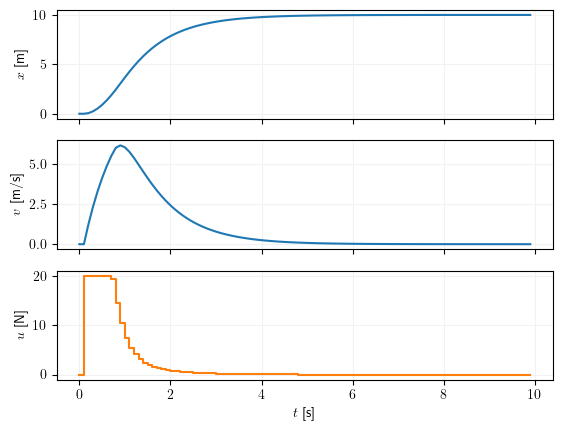

In [15]:
from scipy.signal import place_poles

# Set the desired position [m]
X_DESIRED = 10.0

# Set the maximum input [N]
U_MAX = 20.0

# Compute some gains by picking eigenvalues in the left-half complex plane
EIG = np.array([-2.5, -1.25])
K = place_poles(A, B, EIG)
K_P = K.gain_matrix[0][0]
K_D = K.gain_matrix[0][1]

# Create the controller object
controller = PD_Controller(K_P, K_D, U_MAX, T)

# Initialize some arrays and initial conditions
x = np.zeros((2, N))
u = np.zeros(N)
x[0, 0] = 0.0
x[1, 0] = 0.0
u[0] = 0.0

# Simulate the closed-loop response
for k in range(1, N):
    # Run the robot model for one time step
    x[:, k] = robot_model(x[:, k - 1], u[k - 1])
    # Compute the control signal
    u[k] = controller.compute_PD(X_DESIRED - x[0, k])

# Plot the simulation output
fig4 = plt.figure(4)
# Plot the speed
ax4a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$x$ [m]")
plt.setp(ax4a, xticklabels=[])
ax4b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax4b, xticklabels=[])
# Plot the input
ax4c = plt.subplot(313)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
plt.show()


> __Exercise:__ Play with the eigenvalue locations.  What happens as you move them further into the left-half complex plane?  What if you change the sign?

> __Exercise:__ How might you relate the eigenvalue locations to the transient behaviour of the system?  _Hint:_ The closed-loop system is just a second order system.

## Proportional-Integral-Derivative (PID) Control

Now let's put all of these ideas together into a _proportional-integral-derivative_ (PID) controller. We write a class `PID_Controller` for a PID controller design. 

In [16]:
class PID_Controller:
    """Proportional-Integral-Derivative (PID) controller class."""

    def __init__(self, k_P, k_I, k_D, u_max, T):
        """Constructor method.

        Parameters
        ----------
        k_P : float
            Proportional gain.
        k_I : float
            Integral gain.
        k_D : float
            Derivative gain.
        u_max : float
            Maximum control signal output.
        T : float
            Sample period [s].
        """

        self.k_P = k_P
        self.k_I = k_I
        self.k_D = k_D
        self.T = T
        self.e_last = 0.0
        self.y_last = 0.0
        self.e_integral = 0.0
        self.e_derivative = 0.0
        self.u_max = u_max

    def compute_PID(self, e):
        """Compute the controller output.

        Parameters
        ----------
        e : float
            Error signal.

        Returns
        -------
        u : float
            Control signal (controller output).
        """

        # Compute the (first-order) derivative of the error
        self.e_derivative = (e - self.e_last) / T

        # Compute the control signal
        u = self.k_P * e + self.k_I * self.e_integral + self.k_D * self.e_derivative

        # Check for control signal saturation
        if u >= abs(self.u_max):
            # Saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # Only integrate if control signal is not saturated
            self.e_integral += self.T * e

        # Save the latest error
        self.e_last = e

        return u


Now let's test our PID controller design.  Consider the case where the robot is now going up (or down) a hill with slope $\theta\in(-\frac{\pi}{2},\frac{\pi}{2})$, we have

$$u(t)-c_{\rm d}v(t)-mg\sin\theta=m\dot{v}(t),$$

where $g\approx 9.81$ $[\rm{N}/\rm{kg}]$ is the acceleration due to gravity. We could again try to feed-forward the gravity term $mg\sin\theta$, but it is unlikely, in practice, that we will ever precisely know the mass, gravity, and angle of the slope. 

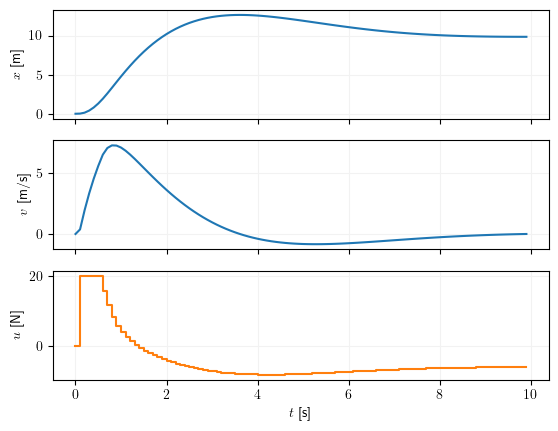

In [17]:
from scipy.signal import place_poles

# Set the desired position [m]
X_DESIRED = 10.0

# Set the maximum input [N]
U_MAX = 20.0

# Compute some gains by picking eigenvalues in the left-half complex plane
EIG = np.array([-2.5, -1.25])
K = place_poles(A, B, EIG)
K_P = K.gain_matrix[0][0]
K_D = K.gain_matrix[0][1]
K_I = 2.0

# Create the controller object
controller = PID_Controller(K_P, K_I, K_D, U_MAX, T)

# Initialize some arrays and initial conditions
x = np.zeros((2, N))
u = np.zeros(N)
x[0, 0] = 0.0
x[1, 0] = 0.0
u[0] = 0.0

# Pick an unknown slope [deg]
SLOPE = 30

# Simulate the closed-loop response
for k in range(1, N):
    # Run the robot model for one time step with unknown slope
    x[:, k] = robot_model(
        x[:, k - 1], u[k - 1] - MASS * 9.91 * np.sin(180 / np.pi * SLOPE)
    )
    # Compute the control signal
    u[k] = controller.compute_PID(X_DESIRED - x[0, k])

# Plot the simulation output
fig5 = plt.figure(4)
# Plot the speed
ax5a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$x$ [m]")
plt.setp(ax5a, xticklabels=[])
ax5b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax5b, xticklabels=[])
# Plot the input
ax5c = plt.subplot(313)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
plt.show()


>__Exercise:__ Explore the following:
>
> 1. What happens when $k_{\rm{I}}=0$ (i.e., no integral action)?  
> 2. Play with the PID gains to observe their effect on the transient and steady-state response of the closed-loop system.
> 3. Is the transient response you obtain for a particular set of gains desireable for a real-world robot?

## Summary of Key Concepts

The proportional-integral-derivative (PID) control structure is widely used, but sometimes not well understood by users.  

In summary, integral action can help a controller to account for unknown disturbances and un-modelled effects.  Without integral action, we may end up with _steady-state errors_.  Derivative action, if necessary (i.e., we have at least a second-order system) is often needed to manipulate the _transient response_ of the closed-loop system to achieve desired performance.

There are many ways to find appropriate values for the PID gains, however this as not been the focus of this particular notebook.

## References

1. G. F. Franklin, J. D. Powell, and A. Emami-Naeini, *Feedback Control of Dynamic Systems*. Pearson Prentice Hall, 5th ed., 2006.